# Results analysis

In [1]:
%load_ext autoreload

In [2]:
%autoreload
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from numpy.lib.format import open_memmap
from itertools import combinations
from scipy.stats import multivariate_normal, entropy, pearsonr
from scripts.data import *
from scripts.preprocessing import *
from scripts.utils import *
from scripts.saliency_metrics import *

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale = 1.3)
%matplotlib inline

## Loading data, add scenes, diagnosis and filter subjs

In [4]:
# load et data
data_path    = './../data/ETFinalCutSampleEC07/ETFinalCutSample/'
results_path = './../results/'

# DeepGazeII
df_wk = pd.read_csv(os.path.join(results_path, 'WK', 'results_nss_diary.csv')) 
df_ff = pd.read_csv(os.path.join(results_path, 'FF', 'results_nss_fractals.csv'))
df_tp = pd.read_csv(os.path.join(results_path, 'TP', 'results_nss_present.csv'))


In [5]:
# load video data
videos_data = load_video_data()
trials_data = load_trials_data()

In [6]:
# load scenes data
wk_data = pd.read_csv('../videos_data/Diary/Diary_of_a_Wimpy_Kid_Trailer-Scenes.csv', header=1)
tp_data = pd.read_csv('../videos_data/Present/The Present_Short-Scenes.csv', header = 1)
ff_data = pd.read_csv('../videos_data/Fractals/Fun_Fractals_v2-Scenes.csv', header = 1)

In [7]:
# add scenes
def calc_scenes(df, df_scenes):
    scenes_vals = [j for j in range(df_scenes.shape[0]) for _ in range(df_scenes.iloc[j]['Start Frame'], df_scenes.iloc[j]['End Frame'])]
    scenes_fram = range(df_scenes.iloc[-1]['End Frame'])
    assert len(scenes_vals) == len(scenes_fram)
    scenes_dict = dict(zip(scenes_fram, scenes_vals))
    new_col = df['FRAME_idx'].map(scenes_dict)
    return new_col

scenes_tp = calc_scenes(df_tp, tp_data)
scenes_wk = calc_scenes(df_wk, wk_data)
scenes_ff = calc_scenes(df_ff, ff_data)
# index starts at 1 for scenes
df_wk['Scenes'] = scenes_wk + 1
df_tp['Scenes'] = scenes_tp + 1
df_ff['Scenes'] = scenes_ff + 1

In [8]:
# final subjects
wk_subjects = pd.read_csv(os.path.join(results_path, 'FinalIDsUsed_WK.csv'), names=['ID'])
ff_subjects = pd.read_csv(os.path.join(results_path, 'FinalIDsUsed_FF.csv'), names=['ID'])
tp_subjects = pd.read_csv(os.path.join(results_path, 'FinalIDsUsed_TP.csv'), names=['ID'])
df_wk_final = df_wk[df_wk.ID.isin(wk_subjects.ID)]
df_ff_final = df_ff[df_ff.ID.isin(ff_subjects.ID)]
df_tp_final = df_tp[df_tp.ID.isin(tp_subjects.ID)]
df_wk_final.shape, df_wk.shape, df_ff_final.shape, df_ff.shape, df_tp_final.shape, df_tp.shape

((317916, 11),
 (690041, 11),
 (237274, 11),
 (506665, 11),
 (322724, 11),
 (684185, 11))

In [9]:
# add diagnosis
valid_diagnosis = ['ADHD-Inattentive Type', 'ADHD-Combined Type', 'ADHD-Hyperactive/Impulsive Type', 'No Diagnosis Given']
def add_diagnosis(df, pheno_path='./../data/PhenoDataFinal.csv'):
    pheno = pd.read_csv(pheno_path)
    #diagnosis_valid = ['ADHD-Inattentive Type', 'ADHD-Combined Type', 'ADHD-Hyperactive/Impulsive Type', 'No Diagnosis Given']
    #pheno = pheno[pheno['DX_01'].isin(diagnosis_valid)]
    pheno = pheno[pheno['DX_01_Cat'] != 'No Diagnosis Given: Incomplete Eval'][['ID', 'DX_01']]
    new_df = df.merge(right=pheno, on='ID', how='inner')
    print(f"Missing {len(df.ID.unique())-len(new_df.ID.unique())} subjects")
    return new_df

df_wk_final = add_diagnosis(df_wk_final)
df_tp_final = add_diagnosis(df_tp_final)
df_ff_final = add_diagnosis(df_ff_final)

Missing 0 subjects
Missing 0 subjects
Missing 0 subjects


In [10]:
pheno = pd.read_csv('./../data/PhenoDataFinal.csv')
#pheno = pd.read_csv('./../data/PhenoDataFinal_diagMerge.csv')
pheno.columns

Index(['Age', 'ID', 'Enroll_Season', 'Enroll_Year', 'Release_Number', 'Sex',
       'CV_Score', 'med_type_01', 'med_type_02', 'med_type_03', 'DX_01',
       'DX_01_Cat', 'DX_01_Sub', 'DX_02', 'DX_02_Cat', 'DX_02_Sub', 'DX_03',
       'DX_03_Cat', 'DX_03_Sub', 'DX_04', 'DX_04_Cat', 'DX_04_Sub', 'DX_05',
       'DX_05_Cat', 'DX_05_Sub', 'DX_06', 'DX_06_Cat', 'DX_06_Sub', 'DX_07',
       'DX_07_Cat', 'DX_07_Sub', 'DX_08', 'DX_08_Cat', 'DX_08_Sub', 'DX_09',
       'DX_09_Cat', 'DX_09_Sub', 'DX_10', 'DX_10_Cat', 'DX_10_Sub', 'Site',
       'EHQ_Total', 'Child_Race', 'SWAN_HY', 'SWAN_IN', 'SWAN_Total',
       'WAIS_FSIQ_SCALE', 'WASI_FSIQ', 'WISC_FSIQ'],
      dtype='object')

In [11]:
# for checking purposes
df_wk_final.drop_duplicates('ID').DX_01.value_counts()
#df_tp_final.DX_01.value_counts()
#df_ff_final.DX_01.value_counts()

ADHD-Combined Type                                           241
ADHD-Inattentive Type                                        236
No Diagnosis Given                                           166
Specific Learning Disorder with Impairment in Reading         22
Generalized Anxiety Disorder                                  20
Social Anxiety (Social Phobia)                                11
Major Depressive Disorder                                      9
Oppositional Defiant Disorder                                  6
Separation Anxiety                                             4
Specific Learning Disorder with Impairment in Mathematics      4
Language Disorder                                              4
Posttraumatic Stress Disorder                                  3
Obsessive-Compulsive Disorder                                  3
Disruptive Mood Dysregulation Disorder                         3
Other Specified Anxiety Disorder                               2
Specific Phobia          

In [12]:
# other
saliency_models_nss = ['NSS_dg', 'NSS_vn', 'NSS_fg', 'NSS_sp']
palette =  dict(zip(saliency_models_nss, sns.color_palette(n_colors=4)))

# NSS values and correlations

In [13]:
def plot_corr_boxplots(df):
    df_corr = df.groupby('ID')[['NSS_dg', 'NSS_vn', 'NSS_fg', 'NSS_sp']].corr() 
    _, ax =  plt.subplots(figsize=(12,6))
    elem = []
    #colors = iter(plt.cm.rainbow(np.linspace(0, 1, 10)))
    sal_combs = list(combinations(df_corr.index.levels[1].to_list(), r=2))
    for i, comb in enumerate(sal_combs):
        elem.append(ax.boxplot(df_corr.unstack()[comb], positions = [i], widths=0.4, patch_artist=True))
        
    #ax.legend([elem["boxes"][0] for elem in elem], comb)
    ax.set_xticklabels([str((x[0][-2:],x[1][-2:])) for x in sal_combs])

    return None

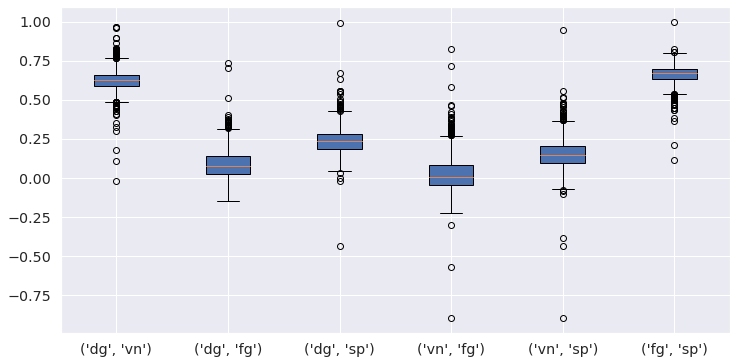

In [14]:
plot_corr_boxplots(df_wk)

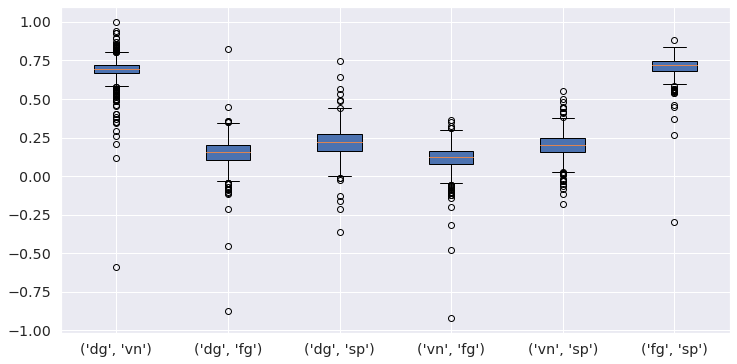

In [15]:
plot_corr_boxplots(df_tp)

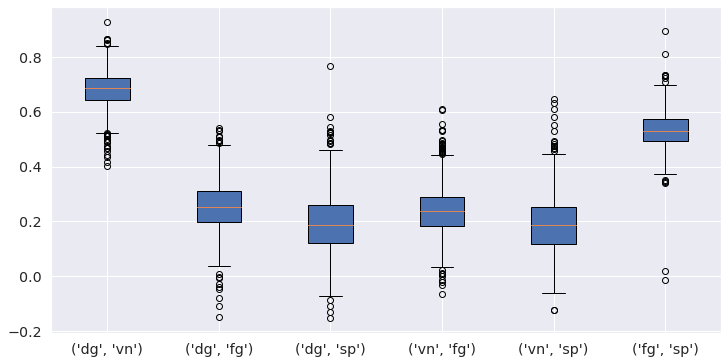

In [16]:
plot_corr_boxplots(df_ff)

# Timeseries analysis: frame level

In [17]:
def plot_timeseries(timeseries, video_full_name, metric_name = 'NSS'):
    _, ax = plt.subplots(figsize=(15,8))
    m = timeseries.mean(axis=1)
    sm = timeseries.std(axis=1)
    plt.plot(m)
    plt.axhline(y = m.mean(), color = 'r', linestyle = '-.', alpha=0.7)
    plt.fill_between(m.index, m - 1 * sm, m + 1 * sm, alpha=0.2);
    ax.set_ylabel(metric_name, fontsize=15)
    #ax.legend('Frame', fontsize=14);
    plt.title(video_full_name, fontsize=18);
    return None

def plot_timeseries_grouped(timeseries, df_diagnosis, video_full_name, metric_name = 'NSS', errorbar = True, valid_diagnosis = None):
    _, ax = plt.subplots(figsize=(15,9))
    lgs = []
    if valid_diagnosis:
        df_grouped = df_diagnosis[df_diagnosis.DX_01.isin(valid_diagnosis)].reset_index()[['ID','DX_01']].groupby('DX_01')
    else:
        df_grouped = df_diagnosis.reset_index()[['ID','DX_01']].groupby('DX_01')
    for diag, group in df_grouped:
        ids = set(group['ID'].to_list()) & set(timeseries.columns)
        ts = timeseries[ids]
        m = ts.mean(axis=1)
        plt.plot(m)
        lgs.append(diag)
        if errorbar:
            sm = ts.std(axis=1)
            plt.fill_between(m.index, m - 1 * sm, m + 1 * sm, alpha=0.2);
            
    ax.set_ylabel(metric_name, fontsize=15)
    ax.legend(lgs, fontsize=14);
    plt.title(video_full_name, fontsize=18);
    
    return None

## Using all subjects

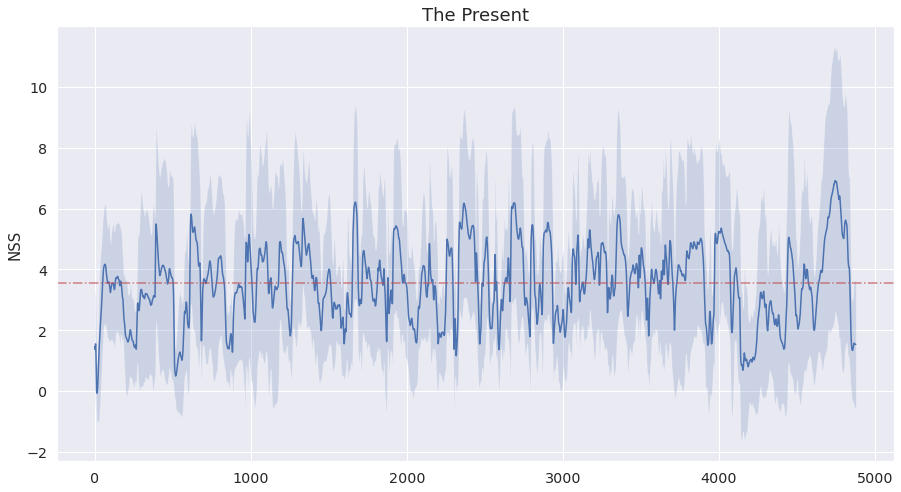

In [18]:
timeseries_tp = create_timeseries_matrix(df_tp.reset_index(), metric_val='NSS_vn', nframes = videos_data.loc['Present','NFrames'].astype(int))
plot_timeseries(timeseries_tp, 'The Present')

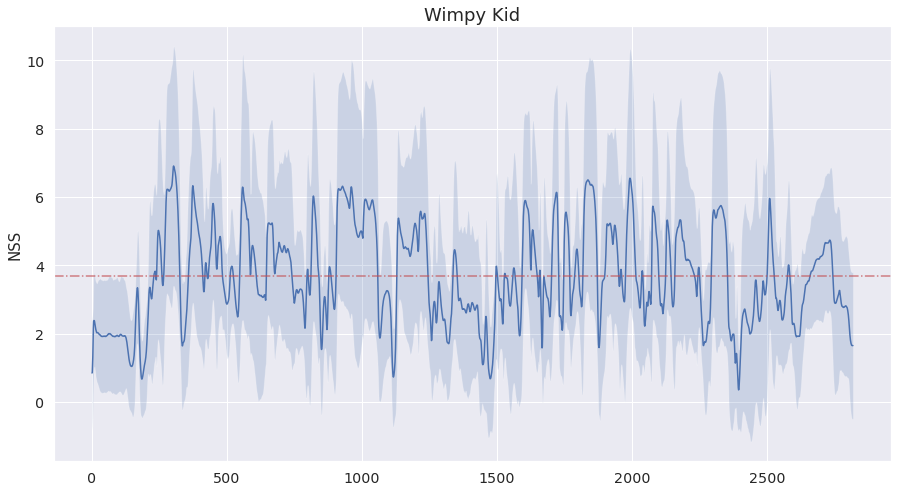

In [19]:
timeseries_wk = create_timeseries_matrix(df_wk.reset_index(), metric_val='NSS_vn', nframes = videos_data.loc['Diary','NFrames'].astype(int))
plot_timeseries(timeseries_wk, 'Wimpy Kid')

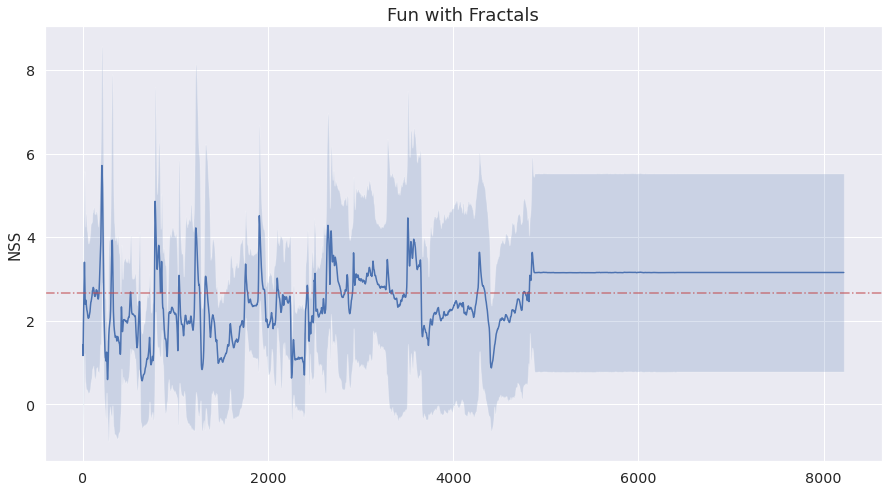

In [20]:
timeseries_ff = create_timeseries_matrix(df_ff.reset_index(), metric_val='NSS_vn', nframes = videos_data.loc['Fractals','NFrames'].astype(int))
plot_timeseries(timeseries_ff, 'Fun with Fractals')

## With filtered subjects



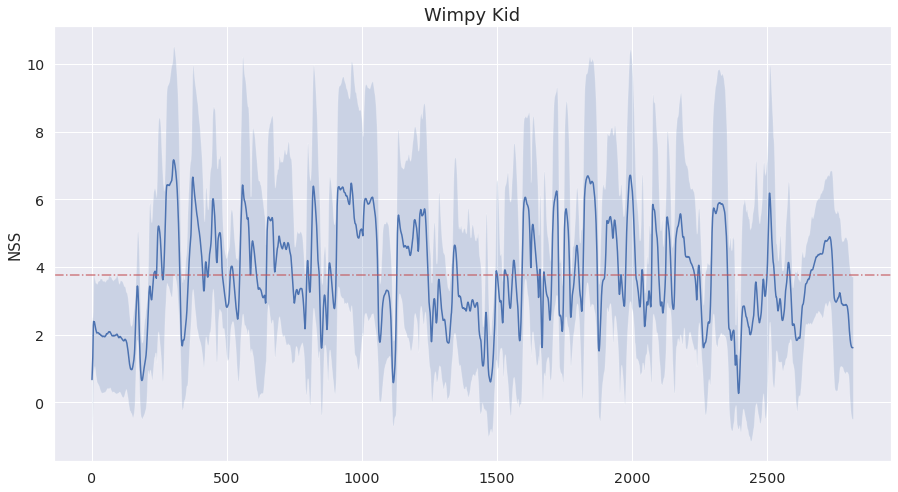

In [21]:
timeseries_wk_f = create_timeseries_matrix(df_wk_final.reset_index(), metric_val='NSS_vn', nframes = videos_data.loc['Diary','NFrames'].astype(int))
plot_timeseries(timeseries_wk_f, 'Wimpy Kid')

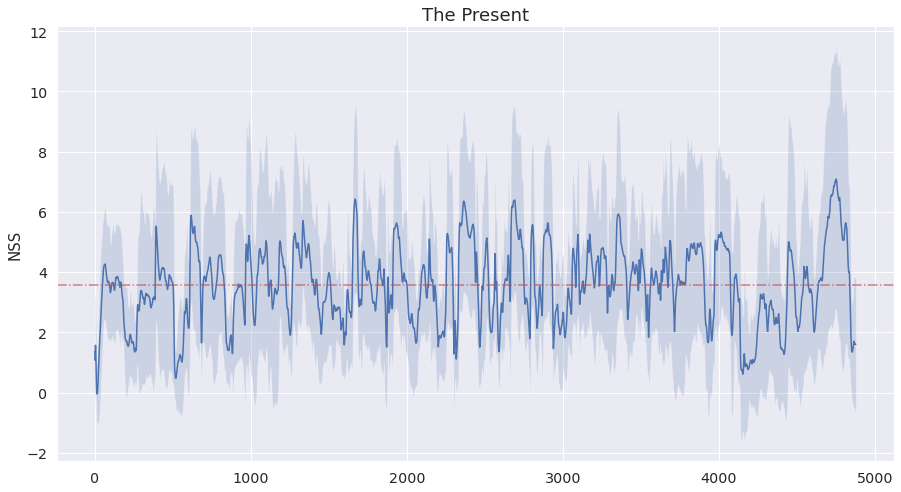

In [22]:
timeseries_tp_f = create_timeseries_matrix(df_tp_final.reset_index(), metric_val='NSS_vn', nframes = videos_data.loc['Present','NFrames'].astype(int))
plot_timeseries(timeseries_tp_f, 'The Present')

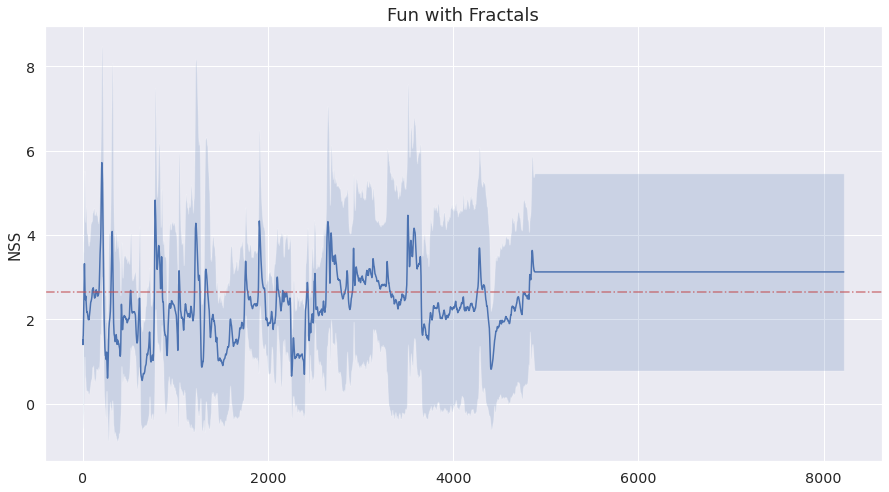

In [23]:
timeseries_ff_f = create_timeseries_matrix(df_ff_final.reset_index(), metric_val='NSS_vn', nframes = videos_data.loc['Fractals','NFrames'].astype(int))
plot_timeseries(timeseries_ff_f, 'Fun with Fractals')

## By diagnosis

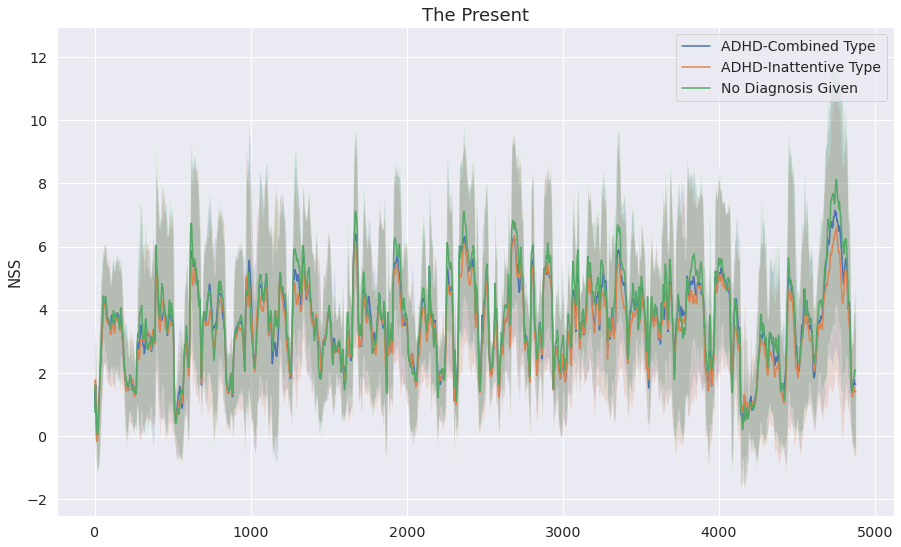

In [24]:
plot_timeseries_grouped(timeseries_tp_f, df_tp_final, 'The Present', errorbar = True, valid_diagnosis=valid_diagnosis)

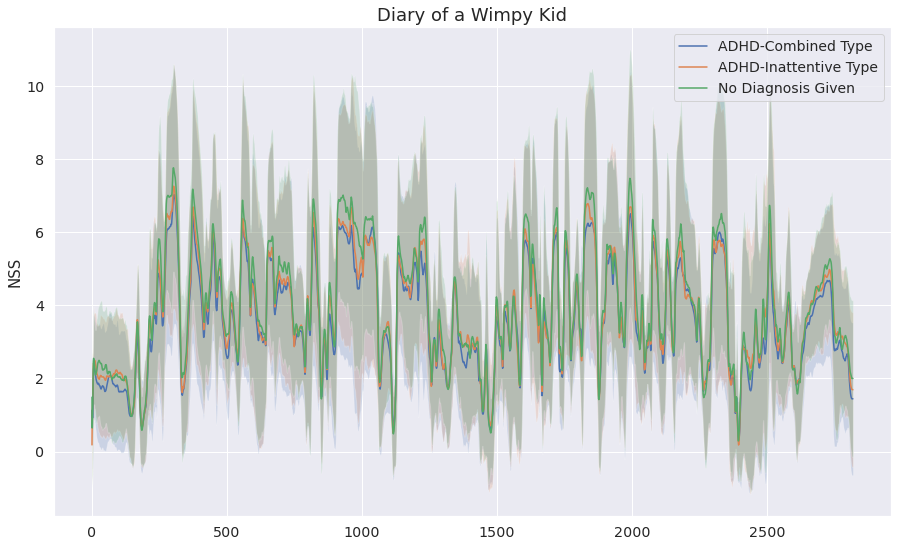

In [25]:
plot_timeseries_grouped(timeseries_wk_f, df_wk_final, 'Diary of a Wimpy Kid', errorbar = True, valid_diagnosis=valid_diagnosis)

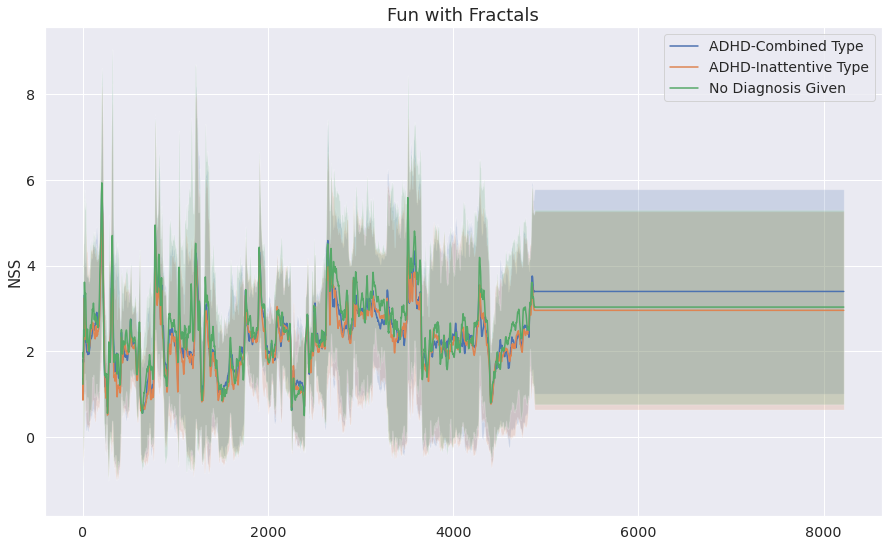

In [26]:
plot_timeseries_grouped(timeseries_ff_f, df_ff_final, 'Fun with Fractals', errorbar = True, valid_diagnosis=valid_diagnosis)

# Scenes analysis

In [27]:
def get_longest_scene(df_scenes, ith=0):
    # ith scene
    aux = df_scenes.sort_values(by='Length (frames)', ascending=False)
    return aux.iloc[ith,:]['Start Frame'], aux.iloc[ith,:]['End Frame'], aux.iloc[ith]['Scene Number']

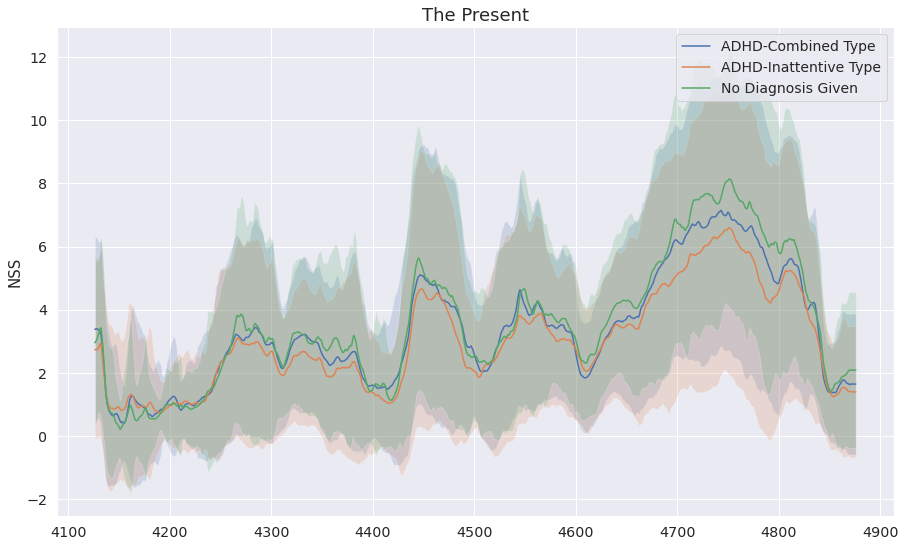

In [28]:
s, e, snumber = get_longest_scene(tp_data)
plot_timeseries_grouped(timeseries_tp_f.iloc[s:e,:], df_tp_final, 'The Present', errorbar = True, valid_diagnosis=valid_diagnosis)

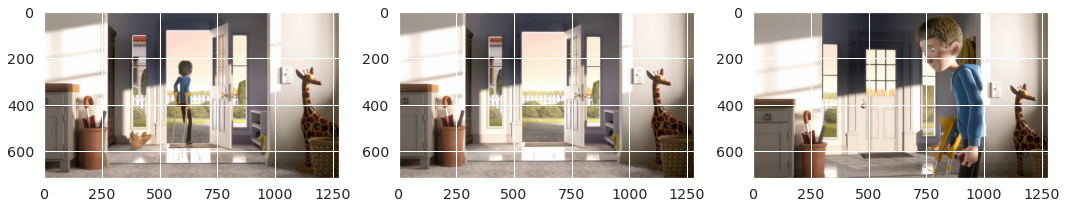

In [29]:
plot_sample_scenes(snumber, 'Present', '../videos_data')

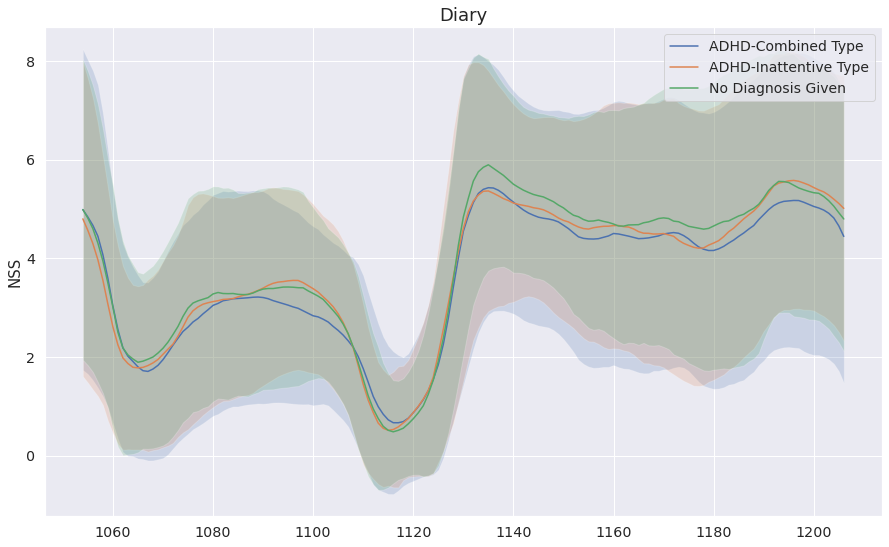

In [30]:
s, e, snumber = get_longest_scene(wk_data)
plot_timeseries_grouped(timeseries_wk_f.iloc[s:e,:], df_wk_final, 'Diary', errorbar = True, valid_diagnosis=valid_diagnosis)

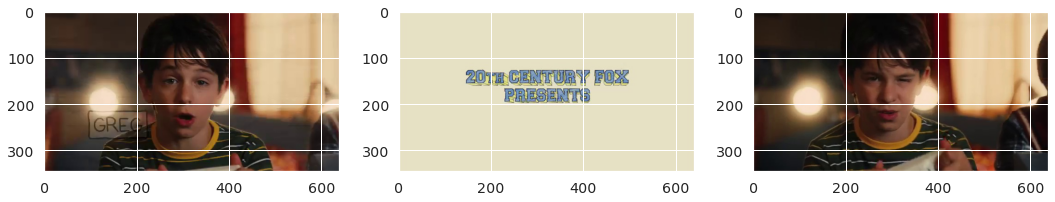

In [31]:
plot_sample_scenes(snumber, 'Diary', '../videos_data')

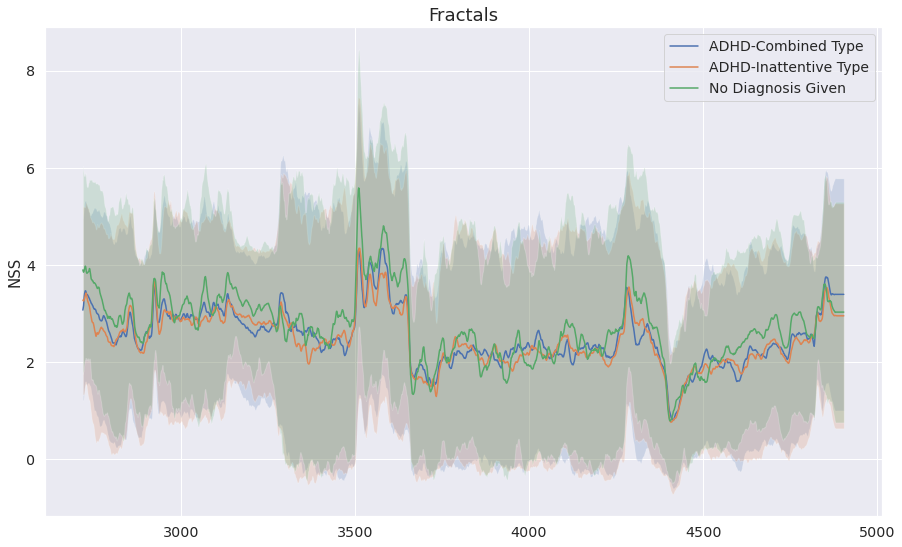

In [32]:
s, e, snumber = get_longest_scene(ff_data, ith=1)
plot_timeseries_grouped(timeseries_ff_f.iloc[s:e,:], df_ff_final, 'Fractals', errorbar = True, valid_diagnosis=valid_diagnosis)

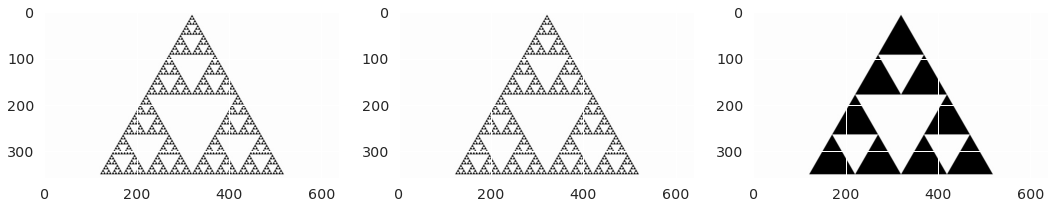

In [33]:
plot_sample_scenes(snumber, 'Fractals', '../videos_data')

## Aling beginning and end of scenes timeseries

In [34]:
def get_scenes_timeseries(df, df_scenes, nframes, min_lenght_seconds = 3, metric = 'NSS_vn'):
    """
    - df contains the nss data for each subject
    - df_scenes contains the scenes considered (Scene Number), the length in frames (Length (frames))
      as extracted from pyscenes
    
    """
    # dado que interpole hacia adelante tire los primeros frames por eso tiro la primera escena
    df_scenes = df_scenes.iloc[1:,:]
    
    # keep only scenes with a minimal lenght
    df_scenes = df_scenes[df_scenes['Length (seconds)']>=min_lenght_seconds]
    
    # mean timeseries
    timeseries = create_timeseries_matrix(df.reset_index(), metric_val=metric, nframes = nframes).dropna().mean(axis=1)
    
    # group by scenes and align to beginning (cut the rest)
    min_length_cut = df_scenes['Length (frames)'].min()
    print(min_length_cut)
    align_start = {}
    align_end   = {}
    
    for _, row in df_scenes.iterrows():
        # check if there are subjects that saw the scene
        if int(row['Scene Number']) in df.Scenes.unique():
            align_start[row['Scene Number']] = timeseries.loc[row['Start Frame'] : row['Start Frame']+min_length_cut-1].to_list()
            align_end[row['Scene Number']]   = timeseries.loc[row['End Frame']-min_length_cut:row['End Frame']-1].to_list()

    #print([len(align_start[s]) for s in align_start.keys()])
    #print([len(align_end[s]) for s in align_end.keys()])
        
    try:
        align_start = pd.DataFrame(align_start)
        align_end   = pd.DataFrame(align_end)
        
    except ValueError:
        print('Hubo un ValueError')
        
    return align_start, align_end, timeseries

In [35]:
a, b, _ = get_scenes_timeseries(df_wk_final, wk_data, nframes = videos_data.loc['Diary','NFrames'].astype(int), metric='NSS_vn')

77


<AxesSubplot:>

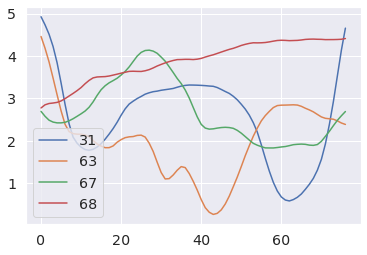

In [36]:
a.plot()

<AxesSubplot:>

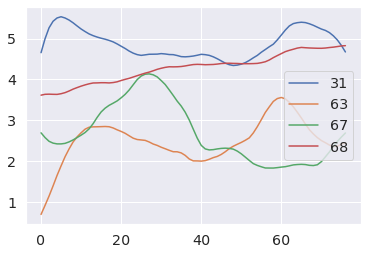

In [37]:
b.plot()

In [38]:
a, b, ts = get_scenes_timeseries(df_tp_final, tp_data, nframes = videos_data.loc['Present','NFrames'].astype(int), metric='NSS_vn')

72


<AxesSubplot:>

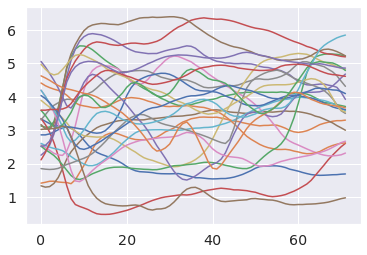

In [39]:
a.plot(legend=False)

<AxesSubplot:>

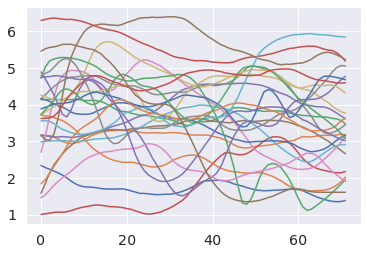

In [40]:
b.plot(legend=False)

In [41]:
a, b, ts = get_scenes_timeseries(df_ff_final, ff_data, nframes = videos_data.loc['Fractals','NFrames'].astype(int), metric='NSS_vn')

90


<AxesSubplot:>

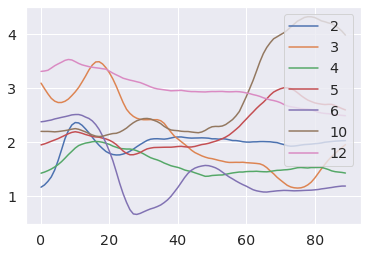

In [42]:
a.plot()

<AxesSubplot:>

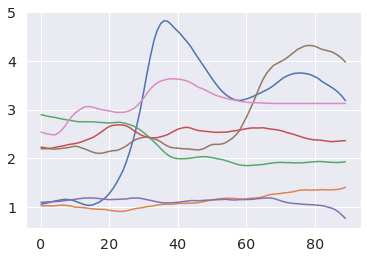

In [43]:
b.plot(legend=False)

In [44]:
def get_scenes_timeseries_erp(df, df_data, nframes, min_lenght_seconds = 3, metric = 'NSS_dg', group_diagnosis = False):
    """
    - df contains the nss data for each subject
    - df_data contains the scenes considered (Scene Number), the length in frames (Length (frames))
      as extracted from pyscenes
    """
    # poner como variable
    do_plot = True
    
    # dado que interpole hacia adelante tire los primeros frames por eso tiro la primera escena
    df_data = df_data.iloc[1:,:]
    
    # keep only scenes with a minimal lenght
    df_data = df_data[df_data['Length (seconds)']>=min_lenght_seconds]
    
    # mean timeseries
    timeseries = create_timeseries_matrix(df.reset_index(), metric_val=metric, nframes = nframes).dropna()
    
    # group by scenes and align to beginning (cut the rest)
    min_length_cut = df_data['Length (frames)'].min()
    print(min_length_cut)
    align_start = {}
    align_end   = {}
    
    for _, row in df_data.iterrows():
        # check if there are subjects that saw the scene
        if int(row['Scene Number']) in df.Scenes.unique():
            align_start[row['Scene Number']] = timeseries.loc[row['Start Frame']:row['Start Frame']+min_length_cut-1,:].reset_index(drop=True)
            align_end[row['Scene Number']]   = timeseries.loc[row['End Frame']-min_length_cut:row['End Frame']-1,:].reset_index(drop=True)

    #print([len(align_start[s]) for s in align_start.keys()])
    #print([len(align_end[s]) for s in align_end.keys()])
        
    try:
        align_start = pd.concat(align_start)
        align_end   = pd.concat(align_end)
        
        if do_plot:
            _, ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
            m = align_start.reset_index().drop(columns =['level_0']).groupby('level_1').mean().mean(axis=1)
            sm = align_start.reset_index().drop(columns =['level_0']).groupby('level_1').mean().sem(axis=1)
            ax[0].plot(m)
            ax[0].fill_between(m.index, m - 1 * sm, m + 1 * sm, alpha=0.2);
            
            #plt.axhline(y = m.mean(), color = 'r', linestyle = '-.', alpha=0.7)
            
            m = align_end.reset_index().drop(columns =['level_0']).groupby('level_1').mean().mean(axis=1)
            sm = align_end.reset_index().drop(columns =['level_0']).groupby('level_1').mean().sem(axis=1)
            ax[1].plot(m)
            ax[1].fill_between(m.index, m - 1 * sm, m + 1 * sm, alpha=0.2);
            
            ax[0].set_ylabel(metric, fontsize=15)
            ax[0].set_xlabel('Start aligned')
            ax[1].set_xlabel('End aligned')
        
    except ValueError:
        print('Hubo un ValueError')
        
    return align_start, align_end, timeseries

77


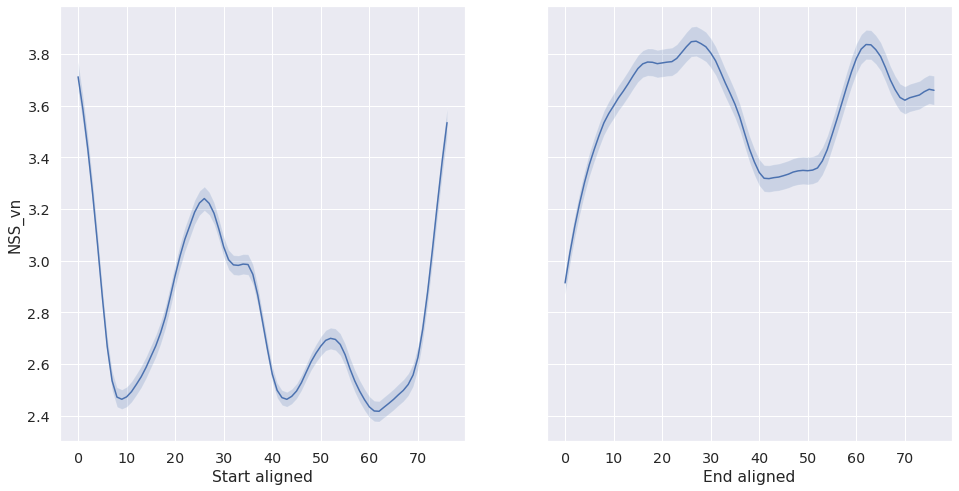

In [45]:
a, b, _ = get_scenes_timeseries_erp(df_wk_final, wk_data, nframes = videos_data.loc['Diary','NFrames'].astype(int), metric='NSS_vn')

72


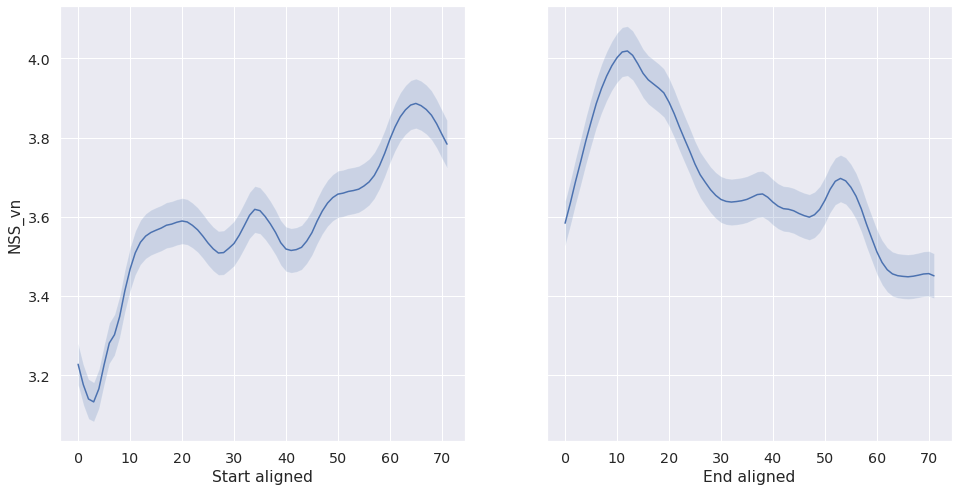

In [46]:
a, b, _ = get_scenes_timeseries_erp(df_tp_final, tp_data, nframes = videos_data.loc['Present','NFrames'].astype(int), metric = 'NSS_vn')

90


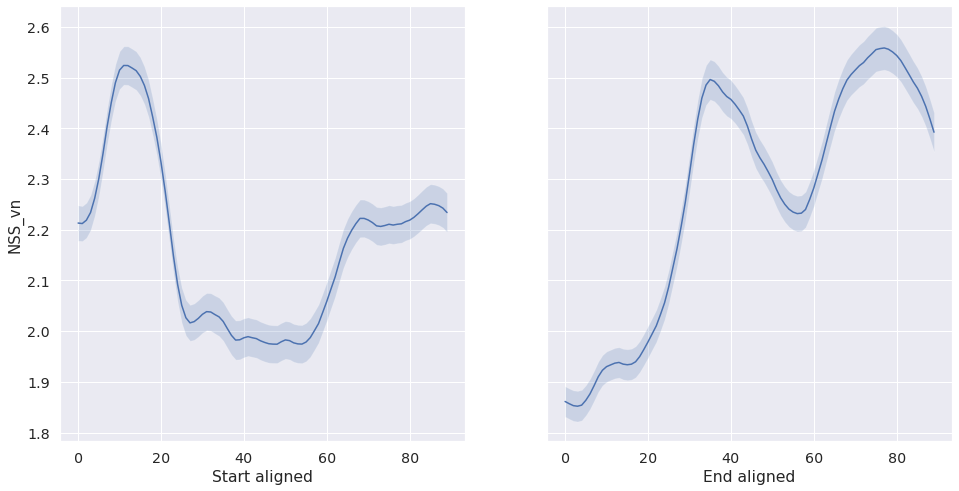

In [47]:
a, b, _ = get_scenes_timeseries_erp(df_ff_final, ff_data, nframes = videos_data.loc['Fractals','NFrames'].astype(int), metric = 'NSS_vn')

# Objects

In [48]:
annotationsWK = pd.read_csv(os.path.join('..','videos_data', 'annotationsWK.csv'))
annotationsWK.columns = ['FRAME_idx', 'object']
annotationsWK['FRAME_idx'] = annotationsWK['FRAME_idx']-1
annotationsWK['scene'] = calc_scenes(annotationsWK, wk_data)
annotationsWK['object'] = annotationsWK['object'].apply(lambda x: x.rstrip().lstrip())

annotationsTP = pd.read_csv(os.path.join('..','videos_data', 'annotationsTP.csv'))
annotationsTP.columns = ['FRAME_idx', 'object']
annotationsTP['FRAME_idx'] = annotationsTP['FRAME_idx']-1
annotationsTP['scene'] = calc_scenes(annotationsTP, tp_data)
annotationsTP['object'] = annotationsTP['object'].apply(lambda x: x.rstrip().lstrip())

annotationsFF = pd.read_csv(os.path.join('..','videos_data', 'annotationsFF.csv'))
annotationsFF.columns = ['FRAME_idx', 'object']
annotationsFF['FRAME_idx']  = annotationsFF['FRAME_idx']-1
annotationsFF['scene']  = calc_scenes(annotationsFF, ff_data)
annotationsFF['object'] = annotationsFF['object'].apply(lambda x: x.rstrip().lstrip())

In [49]:
annotationsTP.object.value_counts()#['scene'].iloc[0][0]

Object    12100
Person     4694
Dog        2384
Text        240
Name: object, dtype: int64

In [50]:
annotationsTP.object.unique()

array(['Person', 'Object', 'Text', 'Dog'], dtype=object)

In [51]:
annotationsWK = pd.get_dummies(annotationsWK, columns = ['object']).groupby('FRAME_idx').sum().drop(columns = 'scene')
annotationsTP = pd.get_dummies(annotationsTP, columns = ['object']).groupby('FRAME_idx').sum().drop(columns = 'scene')
annotationsFF = pd.get_dummies(annotationsFF, columns = ['object']).groupby('FRAME_idx').sum().drop(columns = 'scene')

In [52]:
def annotations_nss_corr(df, nframes, annotations, metric = 'NSS_vn'):
    timeseries = create_timeseries_matrix(df.reset_index(), metric_val=metric, nframes = nframes).dropna()
    ts = timeseries.dropna().mean(axis=1).rename(metric)
    
    # add by scene
    
    return annotations.join(ts, how='inner').corr().iloc[-1,:]

In [53]:
annotations_nss_corr(df_wk_final, videos_data.loc['Diary','NFrames'].astype(int), annotationsWK)

object_Face     -0.013353
object_Object   -0.110835
object_Person   -0.000717
object_Text     -0.292994
NSS_vn           1.000000
Name: NSS_vn, dtype: float64

In [54]:
annotations_nss_corr(df_wk_final, videos_data.loc['Diary','NFrames'].astype(int), annotationsWK, metric='NSS_fg')

object_Face     -0.386741
object_Object   -0.239794
object_Person   -0.452159
object_Text      0.471118
NSS_fg           1.000000
Name: NSS_fg, dtype: float64

In [55]:
annotations_nss_corr(df_tp_final, videos_data.loc['Present','NFrames'].astype(int), annotationsTP)

object_Dog      -0.010561
object_Object   -0.229630
object_Person    0.050366
object_Text     -0.079476
NSS_vn           1.000000
Name: NSS_vn, dtype: float64

In [56]:
annotations_nss_corr(df_tp_final, videos_data.loc['Present','NFrames'].astype(int), annotationsTP, metric='NSS_fg')

object_Dog       0.385676
object_Object    0.215171
object_Person    0.003520
object_Text     -0.059749
NSS_fg           1.000000
Name: NSS_fg, dtype: float64

In [57]:
annotations_nss_corr(df_ff_final, videos_data.loc['Fractals','NFrames'].astype(int), annotationsFF)

object_Object    0.177462
object_Text     -0.100926
NSS_vn           1.000000
Name: NSS_vn, dtype: float64

In [58]:
annotations_nss_corr(df_ff_final, videos_data.loc['Fractals','NFrames'].astype(int), annotationsFF, metric='NSS_fg')

object_Object    0.176789
object_Text     -0.189729
NSS_fg           1.000000
Name: NSS_fg, dtype: float64

# OLD

## Calculations

In [59]:
def calculate_nss_scenes(df, scenes_data, saliency_models = saliency_models_nss):
    nss_scenes = []
    nss_scenes_err = []
    for sal in saliency_models_nss:
        nss_scenes.append(df.groupby(['ID', 'Scenes'])[saliency_models].mean().unstack(level=0)[sal].mean(axis=1))
        nss_scenes_err.append(df.groupby(['ID', 'Scenes'])[saliency_models].mean().unstack(level=0)[sal].sem(axis=1))

    nss_scenes = pd.DataFrame(nss_scenes).T
    nss_scenes.columns = saliency_models
    nss_scenes_err = pd.DataFrame(nss_scenes_err).T
    nss_scenes_err.columns = saliency_models
    
    
    time_index = (pd.to_timedelta(scenes_data['Start Timecode']) + pd.to_timedelta(scenes_data['Length (timecode)'])/2).dt.total_seconds()
    time_index.name = 'scene_time'
    nss_scenes_toplot = nss_scenes.reset_index(drop=True)
    
    nss_scenes_toplot = nss_scenes_toplot.join(time_index).set_index('scene_time')
    nss_scenes_toplot_err = nss_scenes_err.reset_index(drop=True).join(time_index).set_index('scene_time')
    
    fig, ax = plt.subplots(figsize=(18,7))
    nss_scenes_toplot.plot(ax=ax, yerr=nss_scenes_toplot_err)
    ax.set_xlabel('Time (s)')
    
    a = pd.melt(nss_scenes.reset_index(), id_vars=['Scenes'],
        value_vars=saliency_models_nss, var_name='saliency_type', value_name='nss_value')
    b = pd.melt(nss_scenes_err.reset_index(), id_vars=['Scenes'],
        value_vars=saliency_models_nss, var_name='saliency_type', value_name='nss_value')
    return pd.merge(a,b, left_on=['Scenes','saliency_type'], right_on=['Scenes','saliency_type'], how = 'outer', suffixes=('','_err'))

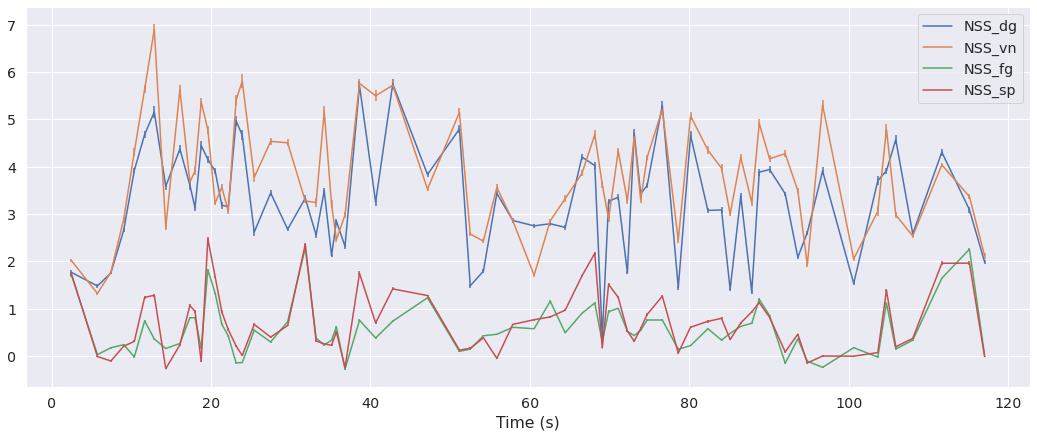

In [60]:
_ = calculate_nss_scenes(df_wk_final, scenes_data=wk_data)

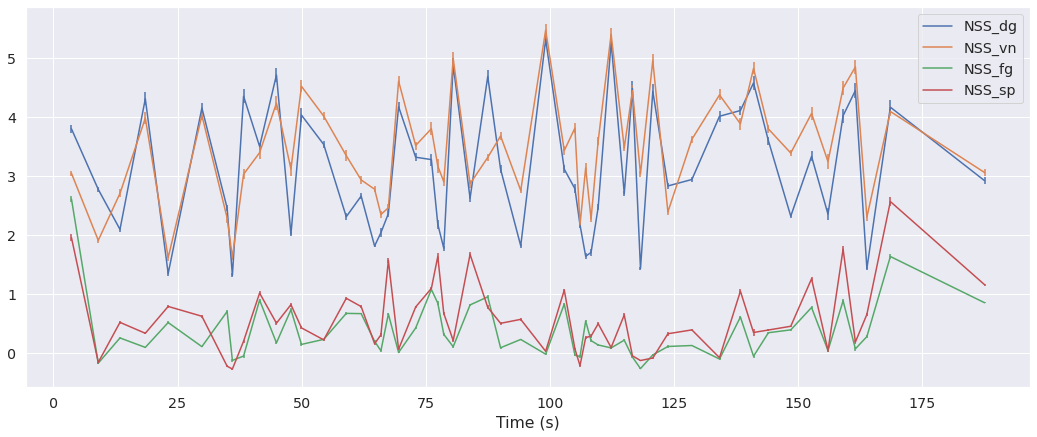

In [61]:
_ = calculate_nss_scenes(df_tp_final, tp_data)

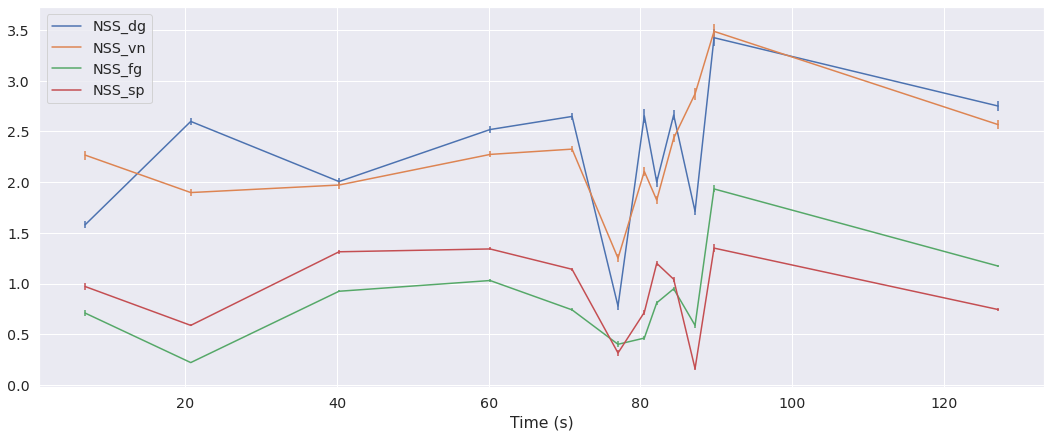

In [62]:
_ = calculate_nss_scenes(df_ff_final, ff_data)

## Correlations with scene length
Ojo que en los df hay nans!!

In [63]:
from scipy.stats import pearsonr

In [64]:
# https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    dfcorr = dfcols.transpose().join(dfcols, how='outer')
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            dfcorr[r][c] = round(pearsonr(df[r], df[c])[0], 4)
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return dfcorr, pvalues

In [65]:
def calculate_scenes_corrs(df, scenes_data, saliency_models, do_plot=True):
    mean_nss = []
    for sal in saliency_models:
        scenes_nss = df.groupby(['ID', 'Scenes'])[saliency_models_nss].mean().unstack(level=0)[sal]
        scenes_nss = scenes_nss.mean(axis=1)
        scenes_nss.name = sal
        mean_nss.append(scenes_nss)
    
    nss_vals_scenes = pd.concat(mean_nss,axis=1).join(scenes_data[['Scene Number','Length (seconds)']].set_index('Scene Number'))
    
    
    ret = pd.melt(nss_vals_scenes, id_vars='Length (seconds)',var_name='saliency', value_name='NSS')
    if do_plot:
        fig, ax = plt.subplots(figsize=(10,7))
        sns.scatterplot(x = 'Length (seconds)', y ='NSS', hue='saliency', data= ret, ax=ax, palette=palette)
    
    corrs = calculate_pvalues(nss_vals_scenes)
    out   = pd.concat([corrs[0].iloc[:-1,-1], corrs[1].iloc[:-1,-1]],axis=1)
    out.columns = [out.columns[0] + ' - corr', out.columns[0] + ' - pval']
    return out

In [66]:
calculate_scenes_corrs(df_wk_final, wk_data, saliency_models_nss, do_plot=False)

,Length (seconds) - corr,Length (seconds) - pval
NSS_dg,-0.0157,0.8972
NSS_vn,-0.1279,0.2915
NSS_fg,0.2688,0.0245
NSS_sp,0.2088,0.0828


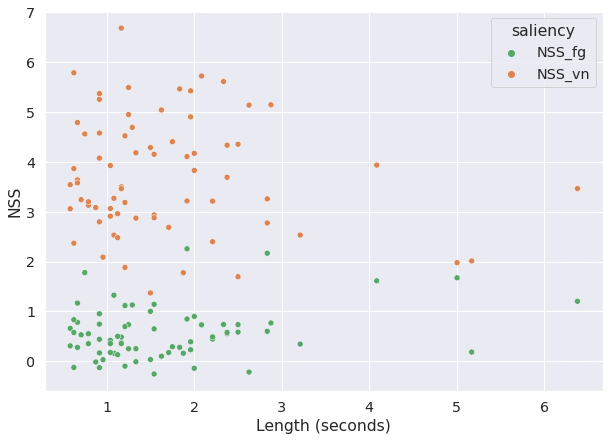

In [67]:
_ = calculate_scenes_corrs(df_wk, wk_data, ['NSS_fg', 'NSS_vn'])

In [68]:
calculate_scenes_corrs(df_tp_final, tp_data, saliency_models_nss, do_plot=False)

,Length (seconds) - corr,Length (seconds) - pval
NSS_dg,0.0911,0.5084
NSS_vn,0.0114,0.9343
NSS_fg,0.236,0.0829
NSS_sp,0.2546,0.0607


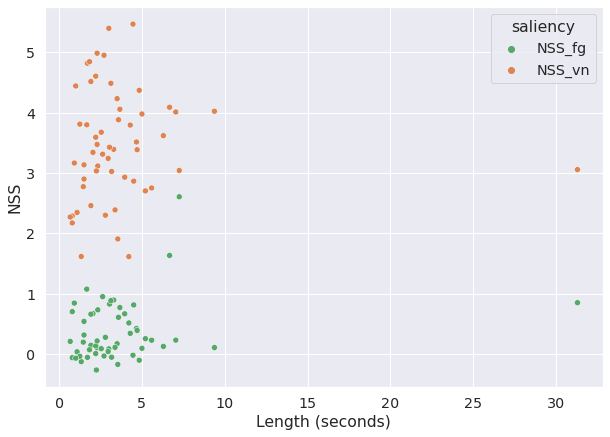

In [69]:
_ = calculate_scenes_corrs(df_tp_final, tp_data, ['NSS_fg', 'NSS_vn'])

In [70]:
calculate_scenes_corrs(df_ff_final, ff_data, saliency_models_nss, do_plot=False)

,Length (seconds) - corr,Length (seconds) - pval
NSS_dg,0.1451,0.6527
NSS_vn,0.0557,0.8634
NSS_fg,0.1892,0.5559
NSS_sp,-0.0159,0.9609


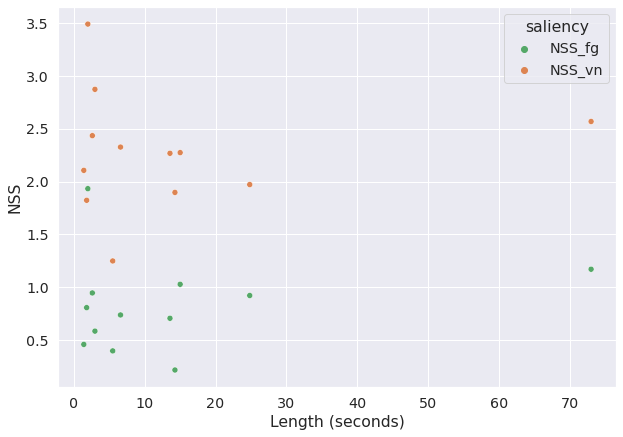

In [71]:
_ = calculate_scenes_corrs(df_ff_final, ff_data, ['NSS_fg', 'NSS_vn'])

### Dispersion acording scene length

In [72]:
def calculate_scenes_mean_dispersion(df, scenes_data, saliency_models, do_plot=True):
    mean_std_nss = []
    std_std_nss  = []
    for sal in saliency_models:
        scenes_nss = df.groupby(['ID', 'Scenes'])[saliency_models_nss].std().unstack(level=0)[sal]
        # mean value of fixations for each scene for each subject
        scenes_nss_mean_std = scenes_nss.mean(axis=1)
        scenes_nss_std_std  = scenes_nss.std(axis=1)
        scenes_nss_mean_std.name = sal
        mean_std_nss.append(scenes_nss_mean_std)
        scenes_nss_std_std.name = sal
        std_std_nss.append(scenes_nss_mean_std)
        
    nss_vals_scenes = pd.concat(mean_std_nss,axis=1).join(scenes_data[['Scene Number','Length (seconds)']].set_index('Scene Number'))
#     nss_vals_scenes = nss_vals_scenes.join(pd.concat(std_std_nss,axis=1), rsuffix = '_std')#[['Scene Number','Length (seconds)']].set_index('Scene Number'))
    nss_vals_scenes.reset_index(inplace=True)
    
    ret = pd.melt(nss_vals_scenes, 
                  value_vars = saliency_models,
                  id_vars = ['Scenes', 'Length (seconds)'], 
                  var_name = 'saliency',
                  value_name = 'NSS_std')
    
#     ret = pd.melt(ret, 
#                   value_vars = [s + '_std' for s in saliency_models],
#                   id_vars = ['Scenes','Length (seconds)','saliency', 'NSS_std'], 
#                   var_name = 'saliency_std',
#                   value_name = 'NSS_disp')

    #     ret = pd.melt(nss_vals_scenes, id_vars='Length (seconds)',var_name='saliency', value_name='NSS')
    if do_plot:
        fig, ax = plt.subplots(figsize=(10,7))
        sns.scatterplot(x = 'Length (seconds)', y ='NSS_std', hue='saliency', data= ret, ax=ax, palette=palette)
    
    corrs = calculate_pvalues(nss_vals_scenes)
    out   = pd.concat([corrs[0].iloc[1:-1,-1], corrs[1].iloc[1:-1,-1]],axis=1)
    out.columns = [out.columns[0] + ' - corr', out.columns[0] + ' - pval']
    return out
#     return ret

In [73]:
calculate_scenes_mean_dispersion(df_wk_final, wk_data, saliency_models_nss, do_plot=False)

,Length (seconds) - corr,Length (seconds) - pval
NSS_dg,0.2739,0.0218
NSS_vn,0.2603,0.0296
NSS_fg,0.4457,0.0001
NSS_sp,0.4429,0.0001


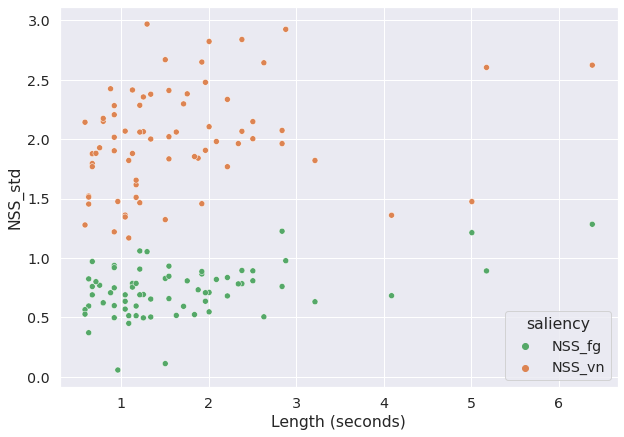

In [74]:
_ = calculate_scenes_mean_dispersion(df_wk_final, wk_data, ['NSS_fg', 'NSS_vn'])

In [75]:
calculate_scenes_mean_dispersion(df_tp_final, tp_data, saliency_models_nss, do_plot=False)

,Length (seconds) - corr,Length (seconds) - pval
NSS_dg,0.3195,0.0174
NSS_vn,0.4805,0.0002
NSS_fg,0.3297,0.014
NSS_sp,0.2849,0.035


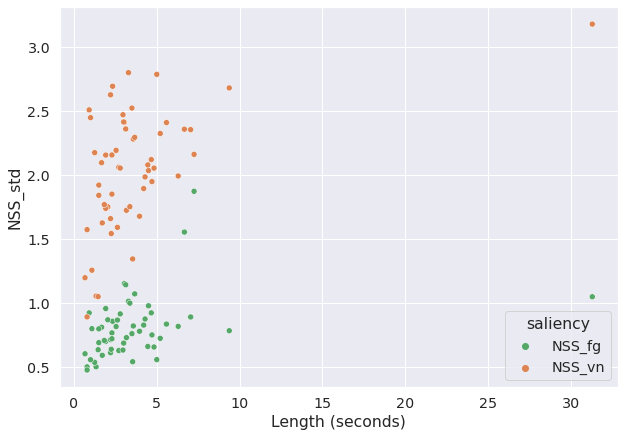

In [76]:
_ = calculate_scenes_mean_dispersion(df_tp_final, tp_data, ['NSS_fg', 'NSS_vn'])

In [77]:
calculate_scenes_mean_dispersion(df_ff_final, ff_data, saliency_models_nss, do_plot=False)

,Length (seconds) - corr,Length (seconds) - pval
NSS_dg,0.4387,0.1536
NSS_vn,0.6084,0.0358
NSS_fg,0.0228,0.944
NSS_sp,0.2684,0.399


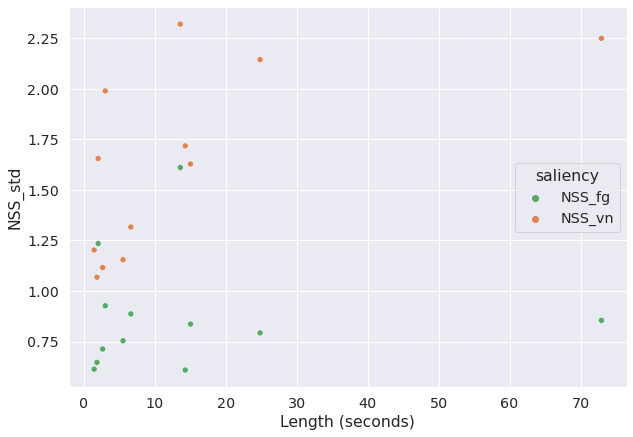

In [78]:
_ = calculate_scenes_mean_dispersion(df_ff_final, ff_data, ['NSS_fg', 'NSS_vn'])

## Scenes entropy

### Entropy cals - RUN ONLY ONCE

In [79]:
from skimage.filters.rank import entropy
from skimage.io import imread
from skimage.morphology import disk
import json

In [80]:
saliency_path = '../videos_sal/'
saliency_fold = 'deepgazeii'

In [81]:
entropy_vals = {'Diary':[], 'Fractals':[], 'Present':[]}
for vid, vid_fold in videos_data.iloc[:3,0].iteritems():
    vid_fold = vid_fold[:-4]
    path = os.path.join(saliency_path, saliency_fold, vid_fold)
    for img_file in sorted(os.listdir(path)):
        img= imread(os.path.join(path,img_file), as_gray=True)
        entropy_vals[vid].append(entropy(img, disk(5)).mean())
    print('Done: ',vid)

FileNotFoundError: [Errno 2] No such file or directory: '../videos_sal/deepgazeii/Diary_of_a_Wimpy_Kid_Trailer'

In [ ]:
with open(os.path.join(saliency_path, saliency_fold, 'entropy_vals.json'), 'w') as fp:
    json.dump(entropy_vals, fp)

In [ ]:
saliency_fold = 'vinet'
entropy_vals_vn = {'Diary':[], 'Fractals':[], 'Present':[]}
for vid, vid_fold in videos_data.iloc[:3,0].iteritems():
    vid_fold = vid_fold[:-4]
    path = os.path.join(saliency_path, saliency_fold, vid_fold)
    for img_file in sorted(os.listdir(path)):
        try:
            img= imread(os.path.join(path,img_file), as_gray=True)
        except:
            print(os.path.join(path,img_file))
        entropy_vals_vn[vid].append(entropy(img, disk(5)).mean())
    print('Done: ',vid)

../videos_sal/vinet/Diary_of_a_Wimpy_Kid_Trailer/.ipynb_checkpoints
Done:  Diary
Done:  Fractals
Done:  Present


In [ ]:
with open(os.path.join(saliency_path, saliency_fold, 'entropy_vals.json'), 'w') as fp:
    json.dump(entropy_vals_vn, fp)

In [ ]:
saliency_fold = 'finegrained'
entropy_vals_fg = {'Diary':[], 'Fractals':[], 'Present':[]}
for vid, vid_fold in videos_data.iloc[:3,0].iteritems():
    vid_fold = vid_fold[:-4]
    path = os.path.join(saliency_path, saliency_fold, vid_fold)
    for img_file in sorted(os.listdir(path)):
        try:
            img= imread(os.path.join(path,img_file), as_gray=True)
        except:
            print(os.path.join(path,img_file))
        entropy_vals_fg[vid].append(entropy(img, disk(5)).mean())
    print('Done: ',vid)

../videos_sal/finegrained/Diary_of_a_Wimpy_Kid_Trailer/.ipynb_checkpoints
Done:  Diary
Done:  Fractals
Done:  Present


In [ ]:
with open(os.path.join(saliency_path, saliency_fold, 'entropy_vals.json'), 'w') as fp:
    json.dump(entropy_vals_fg, fp)

### Load entropy

In [ ]:
saliency_path = '../videos_sal/'

In [ ]:
saliency_fold = 'deepgazeii'
with open(os.path.join(saliency_path, saliency_fold,'entropy_vals.json')) as json_file:
    dg_entropy = json.load(json_file)

saliency_fold = 'finegrained'
with open(os.path.join(saliency_path, saliency_fold,'entropy_vals.json')) as json_file:
    fg_entropy = json.load(json_file)

saliency_fold = 'spectral'
with open(os.path.join(saliency_path, saliency_fold,'entropy_vals.json')) as json_file:
    sp_entropy = json.load(json_file)

saliency_fold = 'vinet'
with open(os.path.join(saliency_path, saliency_fold,'entropy_vals.json')) as json_file:
    vn_entropy = json.load(json_file)

In [ ]:
sal_dict = dict(zip(saliency_models_nss,[dg_entropy, vn_entropy, fg_entropy, sp_entropy]))

ent = []
for vid in videos_data.iloc[:3,0].index:
    ent_vid = []
    for sal in sal_dict.keys():
        sal_vid_ent = sal_dict[sal][vid]
        ent_vid.append(sal_vid_ent)
    df = pd.DataFrame(ent_vid).T
    df.columns = saliency_models_nss
    ent.append(df)
ent = dict(zip(videos_data.iloc[:3,0].index, ent))

In [ ]:
scene_vid = dict(zip(videos_data.iloc[:3,0].index,[wk_data,ff_data,tp_data]))
for vid in scene_vid.keys():
    ent[vid]['FRAME_idx'] = ent[vid].index
    aux = calc_scenes(ent[vid], scene_vid[vid])
    aux = pd.DataFrame([a.values for a in aux], columns = ['Scenes']).fillna(scene_vid[vid]['Scene Number'].iloc[-1])
    aux['Scenes'] = aux['Scenes'].astype(int)
    ent[vid] = ent[vid].join(aux)#.drop(columns=['FRAME_idx'])
    ent[vid] = ent[vid].groupby('Scenes').mean()

### Correlation NSS with entropy per scene

In [ ]:
dg_entropy['Present'][500]

0.5267457415058924

In [ ]:
vn_entropy['Present'][500]

0.4649167053942976

In [ ]:
sp_entropy['Present'][500]

1.2527462321725449

In [ ]:
fg_entropy['Present'][500]

3.2436439612989205

In [ ]:
def calculate_scenes_corrs_entropy(df, df_entropy, scenes_data, saliency_models,var='mean'):
    mean_nss = []
    n = len(saliency_models)
    for sal in saliency_models:
        scenes_nss = df.groupby(['ID', 'Scenes'])[saliency_models].mean().unstack(level=0)[sal]
        if var=='mean':
            scenes_nss = scenes_nss.mean(axis=1)
        elif var=='dispersion':
            scenes_nss = scenes_nss.std(axis=1)
        else:
            print('No valid var type')
            return None
        scenes_nss.name = sal
        mean_nss.append(scenes_nss)
    
    df_nss = pd.DataFrame(mean_nss).T
    df = df_nss.join(df_entropy, rsuffix='_ent')
    fig, ax = plt.subplots(1,n,figsize=(22,7))
    
    for i, sal in enumerate(saliency_models):
        sns.scatterplot(x = sal+'_ent', y = sal, data = df, ax = ax[i], palette = palette[sal])
        ax[i].set_ylabel('')
    ax[0].set_ylabel('NSS')
    return df.corr().iloc[:n,n:]

,NSS_dg_ent,NSS_vn_ent,NSS_fg_ent,NSS_sp_ent,FRAME_idx
NSS_dg,0.005364,0.230598,-0.180816,-0.208860,-0.029632
NSS_vn,-0.056649,0.191723,-0.175426,-0.187725,-0.136670
NSS_fg,-0.221534,0.107834,-0.361006,-0.428996,0.018756
NSS_sp,-0.295332,-0.109343,-0.319916,-0.407864,-0.027766


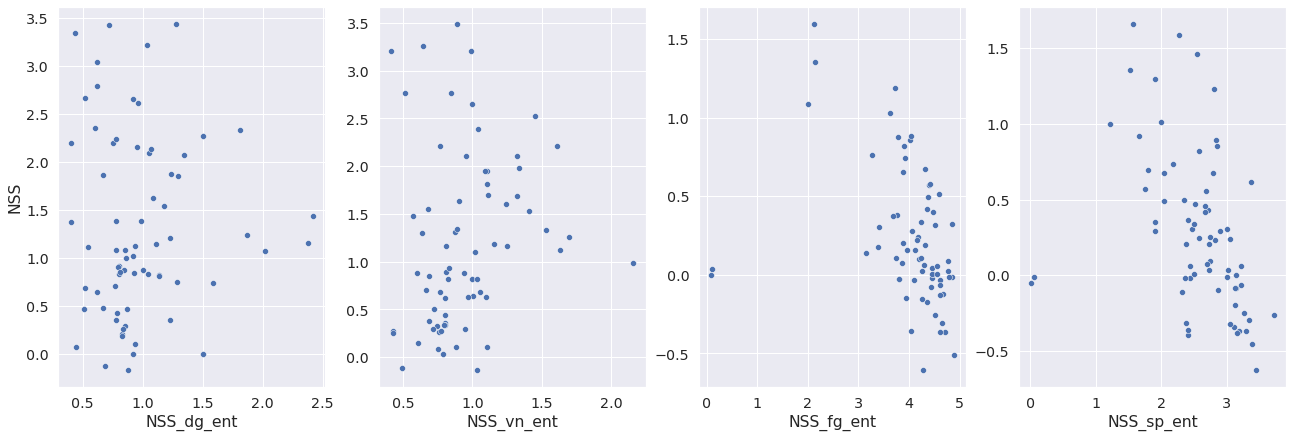

In [ ]:
calculate_scenes_corrs_entropy(df_wk, ent['Diary'], wk_data, saliency_models_nss)

,NSS_dg_ent,NSS_vn_ent,NSS_fg_ent,NSS_sp_ent,FRAME_idx
NSS_dg,0.005364,0.230598,-0.180816,-0.208860,-0.029632
NSS_vn,-0.056649,0.191723,-0.175426,-0.187725,-0.136670
NSS_fg,-0.221534,0.107834,-0.361006,-0.428996,0.018756
NSS_sp,-0.295332,-0.109343,-0.319916,-0.407864,-0.027766


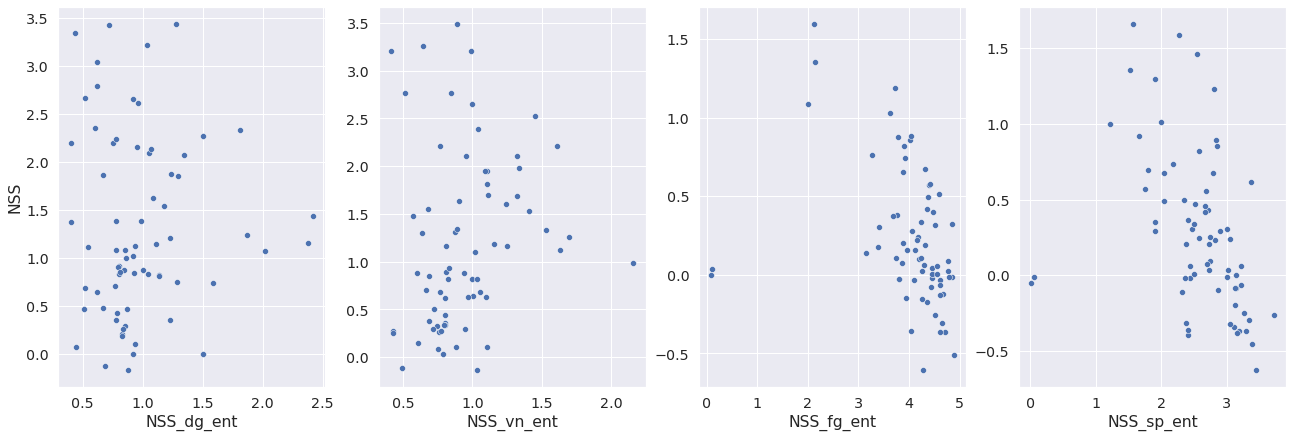

In [ ]:
calculate_scenes_corrs_entropy(df_wk, ent['Diary'], wk_data, saliency_models_nss)

,NSS_dg_ent,NSS_vn_ent,NSS_fg_ent,NSS_sp_ent,FRAME_idx
NSS_dg,-0.314803,-0.140379,-0.257928,-0.247575,0.142744
NSS_vn,-0.247675,0.115748,-0.151552,-0.053558,0.251206
NSS_fg,-0.108825,0.022230,-0.307651,-0.165493,-0.210075
NSS_sp,-0.318599,-0.071841,-0.119182,-0.086229,0.010192


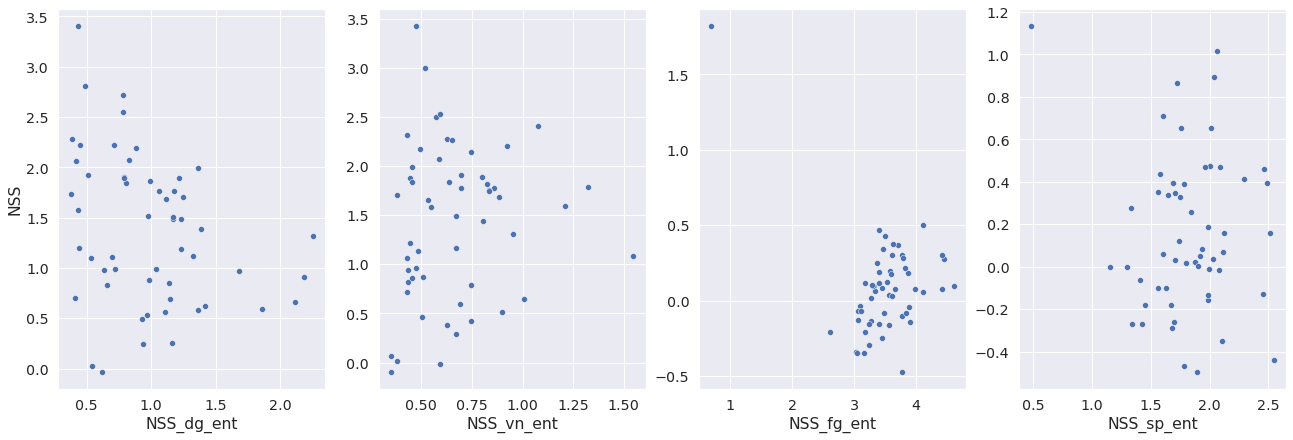

In [ ]:
calculate_scenes_corrs_entropy(df_tp, ent['Present'], tp_data, saliency_models_nss)

### Correlation NSS dispersion with entropy per scene

,NSS_dg_ent,NSS_vn_ent,NSS_fg_ent,NSS_sp_ent,FRAME_idx
NSS_dg,-0.175919,0.105112,-0.158924,-0.192304,-0.058327
NSS_vn,-0.047614,0.027440,-0.132010,-0.138007,-0.223275
NSS_fg,-0.280669,-0.227884,0.233742,0.160875,-0.110460
NSS_sp,-0.258064,-0.259681,-0.008341,-0.075978,-0.200690


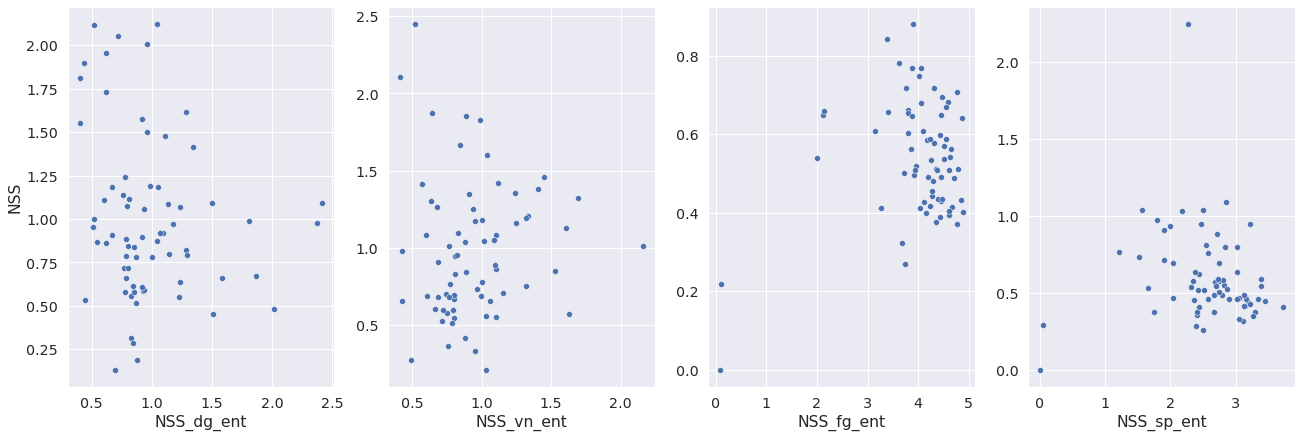

In [ ]:
calculate_scenes_corrs_entropy(df_wk, ent['Diary'], wk_data, saliency_models_nss, var='dispersion')

,NSS_dg_ent,NSS_vn_ent,NSS_fg_ent,NSS_sp_ent,FRAME_idx
NSS_dg,-0.558916,-0.293078,-0.217054,-0.316573,0.184599
NSS_vn,-0.415024,-0.200881,-0.074052,-0.093893,0.317635
NSS_fg,-0.092379,0.216733,-0.172284,-0.124721,-0.061794
NSS_sp,-0.277948,0.030544,0.032808,0.027911,0.018542


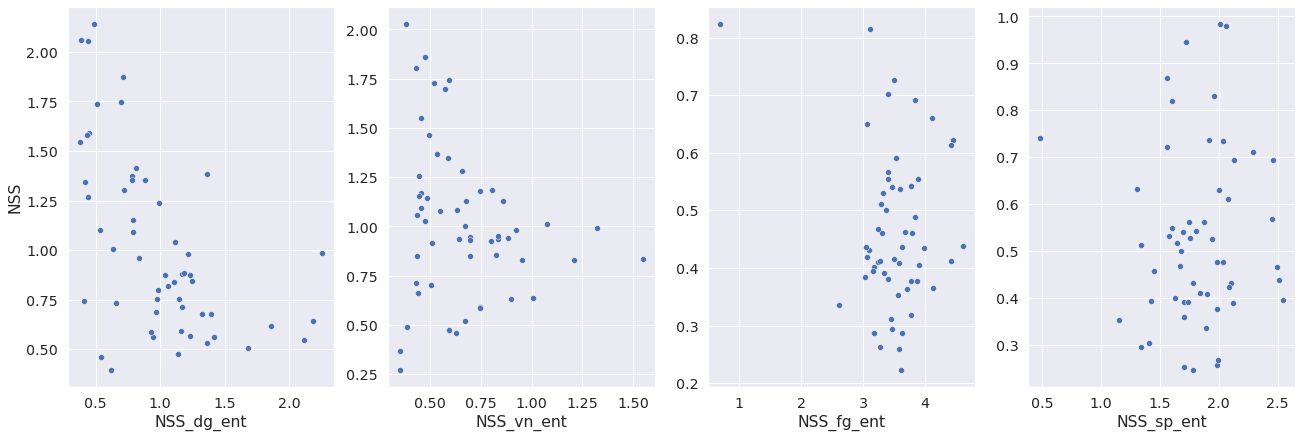

In [ ]:
calculate_scenes_corrs_entropy(df_tp, ent['Present'], tp_data, saliency_models_nss, var='dispersion')

## Other features - Faces